## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(8, 9):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:29<00:00,  3.70it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_8"])
layer_hs_array.shape

(10000, 267264)

## Layer 8 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

dim_reduced_vecs = layer_hs_array

# random_projector = GaussianRandomProjection(random_state = 42)
# dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 267264)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 267264)
(8000,)
(2000, 267264)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 267264D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 4.07 s
Outer iteration 0 / 10
  Iteration 19 (11.13 s, search 7.44 s): objective=2415.93 imbalance=1.040 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (22.28 s, search 14.90 s): objective=2408.92 imbalance=1.223 nsplit=0       
Outer iteration 2 / 10
  Iteration 19 (33.37 s, search 22.32 s): objective=2416 imbalance=1.043 nsplit=0         
Objective improved: keep new clusters
Outer iteration 3 / 10
  Iteration 19 (44.48 s, search 29.77 s): objective=2410.3 imbalance=1.128 nsplit=0        
Outer iteration 4 / 10
  Iteration 19 (55.58 s, search 37.23 s): objective=2402.64 imbalance=1.483 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (66.69 s, search 44.67 s): objective=2357.24 imbalance=1.693 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (77.80 s, search 52.12 s): objective=2409.11 imb

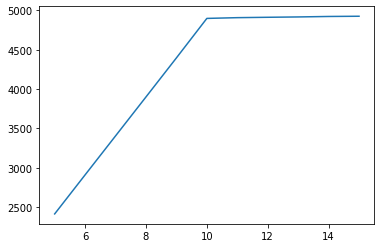

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 267264D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 1.30 s
Outer iteration 0 / 10
  Iteration 19 (22.42 s, search 14.95 s): objective=4871.46 imbalance=1.286 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (45.03 s, search 29.95 s): objective=4890.16 imbalance=1.310 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (67.55 s, search 44.93 s): objective=4896.94 imbalance=1.204 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 10
  Iteration 19 (90.00 s, search 59.87 s): objective=4887.28 imbalance=1.208 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (112.45 s, search 74.83 s): objective=4824.3 imbalance=2.521 nsplit=0        
Outer iteration 5 / 10
  Iteration 19 (135.04 s, search 89.84 s): objective=4874.2 imbalance=1.199 nsplit=0        
Outer iteration 6 / 10
  Iteration 19 (157.46 s, search 104.78 s): objective=4887.06 imb

4896.9404296875

In [15]:
kmeans.centroids #cluster centers

array([[-1.3076481e-02,  8.9642098e-03,  8.6435732e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.4904572e-03,  3.7638329e-03,  3.6292048e-03, ...,
        -2.1075395e-05,  2.8485474e-05, -2.8997210e-05],
       [-1.2782276e-02,  8.7625254e-03,  8.4490944e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-6.4624161e-03,  4.4301180e-03,  4.2716572e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.2288719e-02,  8.4242290e-03,  8.1228642e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.3217018e-02,  9.0605393e-03,  8.7364754e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000025
1.0000035
1.000002
1.0000005
1.0000056
1.0000013
1.000006
1.0000044
1.0000012
1.0000004


In [17]:
kmeans.obj #inertia at each iteration

array([2996.50341797, 4837.18701172, 4853.25341797, 4858.29589844,
       4863.05810547, 4868.06152344, 4870.02734375, 4870.83154297,
       4871.15185547, 4871.29052734, 4871.35644531, 4871.38867188,
       4871.42871094, 4871.4296875 , 4871.44677734, 4871.46044922,
       4871.45703125, 4871.45703125, 4871.45703125, 4871.45703125,
       3022.89575195, 4847.16845703, 4862.88134766, 4870.30078125,
       4875.40771484, 4878.96728516, 4881.70605469, 4883.04443359,
       4883.47607422, 4883.65966797, 4883.82177734, 4884.05566406,
       4884.32714844, 4884.71728516, 4885.24560547, 4886.56347656,
       4887.92724609, 4888.56933594, 4889.60253906, 4890.15576172,
       3042.34594727, 4870.86572266, 4887.35595703, 4890.54736328,
       4892.05761719, 4893.05371094, 4893.75488281, 4894.82763672,
       4896.34716797, 4896.73730469, 4896.80322266, 4896.859375  ,
       4896.88916016, 4896.91210938, 4896.93798828, 4896.9375    ,
       4896.94287109, 4896.94335938, 4896.94140625, 4896.94042

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

6    1568
4    1128
8    1026
1     911
9     878
7     693
3     582
5     469
0     434
2     311
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[3, 10, 10, 8, 1, 5, 9, 2, 7, 6]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 3, 1: 10, 2: 10, 3: 8, 4: 1, 5: 5, 6: 9, 7: 2, 8: 7, 9: 6}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 9,  2,  9, ...,  9, 10,  1])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.1675
Prompt 2 Accuracy:  0.11
Prompt 3 Accuracy:  0.5425
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.405
Prompt 6 Accuracy:  0.17375
Prompt 7 Accuracy:  0.21875
Prompt 8 Accuracy:  0.125
Prompt 9 Accuracy:  0.22
Prompt 10 Accuracy:  0.5525


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.2515


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

6    411
8    283
4    280
9    208
1    203
7    185
3    136
5    117
0    103
2     74
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 8,  2,  9, ..., 10,  1, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.095
Prompt 2 Accuracy:  0.065
Prompt 3 Accuracy:  0.515
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.435
Prompt 6 Accuracy:  0.19
Prompt 7 Accuracy:  0.23
Prompt 8 Accuracy:  0.11
Prompt 9 Accuracy:  0.24
Prompt 10 Accuracy:  0.505


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.2385


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

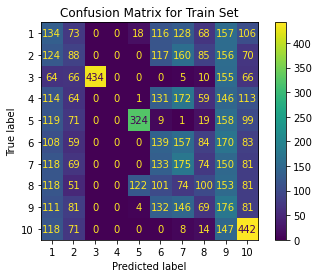

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

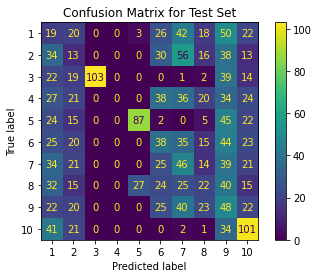

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()